In [25]:
import datetime as dt
import os
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math


def pull_stock_data(tickers:str, start:str, end:str, interval:str, stripdateindex:str, column:str) -> pd.DataFrame:
    """
    Returns a dataframe with chosen stock information for last day of the month.

    Parameters:
    -------------
    tickers (str): Yahoo finance tickers for companies divided ONLY by single space
    start (str): start date of the period (format yyyy-mm-dd)
    end (str): end date of the period (format yyyy-mm-dd)
    interval (str): wanted interval (1d, 1m, 1y)
    stripdateindex (str): argument for stripping datetime index down (d - day, m - month, y- year)
    columns (list): list of wanted values, args same as in yahoo finance
    """
    # data download
    df = yf.download(tickers = tickers, start = start, end = end, interval = interval, groupby = 'ticker')
    # changing index from datetime to just year and month
    df['Date'] = df.index
    dfg = df.groupby([df.index.year, df.index.month], as_index=False).last()
    dfg.reset_index(inplace=True, drop=True)
    dfg.set_index('Date', inplace=True)
    dfg.index = pd.to_datetime(dfg.index).to_period(stripdateindex)
    # dropping na rows
    dfg.dropna(inplace = True)
    return dfg[column]

    
def save_to_desktop(dataframe:pd.DataFrame, file_name:str):
    """
    Saves dataframe to desktop in csv format under filename provided

    Parameters:
    ------------
    dataframe (pd.DataFrame): dataframe that is to be saved
    file_name (str): name of the file
    """
    # defining path to desktop on running unit
    desktop = os.path.join(os.path.join(os.environ['USERPROFILE']), 'Desktop')
    # saving file under chosen name on desktop
    dataframe.to_csv(desktop+'/'+file_name+'.csv', sep=';')



In [26]:
#tick = "BTC-USD ETH-USD XRP-USD ADA-USD SOL-USD DOGE-USD BUSD-USD MATIC-USD DOT-USD LTC-USD"
tick = 'BTC-USD LTC-USD NMC-USD' #XRP DOGE 
st = '2000-12-01'
en = '2020-12-31'
intv = '1d'
strpdt = 'm'
col = ['Close', 'Volume']

dftest = pull_stock_data(tick, st, en, intv, strpdt, col)
dftest.head(5)

[*********************100%***********************]  3 of 3 completed


C:\Users\maxim\AppData\Local\Temp\ipykernel_6560\4046405710.py:33: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  dfg.index = pd.to_datetime(dfg.index).to_period(stripdateindex)


Close                       Volume                 
            BTC-USD  LTC-USD   NMC-USD   BTC-USD  LTC-USD NMC-USD
Date                                                             
2014-09  386.944000  4.47473  1.095370  34707300  2456420   59063
2014-10  338.321014  3.75400  0.896075  12545400  2303900   16492
2014-11  378.046997  3.57609  0.910943   9194440  1206290   12833
2014-12  320.192993  2.71893  0.715574  13942900  1577550   16548
2015-01  217.464005  1.87350  0.470195  23348200  1205140    8811

## % change and excess returns

In [38]:
# We only care about returns -
df1 = dftest['Close']
df1 = df1.pct_change()
df1.head()

,BTC-USD,LTC-USD,NMC-USD
Date,,,
2014-09,NaN,NaN,NaN
2014-10,-0.125659,-0.161067,-0.181943
2014-11,0.117421,-0.047392,0.016592
2014-12,-0.153034,-0.239692,-0.214469
2015-01,-0.320835,-0.310942,-0.342912


In [39]:
#save_to_desktop(dfsave, 'data')

#### Process F-F risk free rates downloaded previously

In [40]:
fama = pd.read_csv(r"F-F_Research_Data_Factors.CSV", sep=';')
fama['Date'] = pd.to_datetime(fama['Date'].astype('string'), format='%Y%m')
fama.set_index('Date', inplace=True)
fama.index = fama.index.to_period('m')
# Values given in CSV are plain percentages - division by 100
fama = fama.divide(100)
fama.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07,0.0296,-0.0256,-0.0243,0.0022
1926-08,0.0264,-0.0117,0.0382,0.0025
1926-09,0.0036,-0.0140,0.0013,0.0023
1926-10,-0.0324,-0.0009,0.0070,0.0032
1926-11,0.0253,-0.0010,-0.0051,0.0031


In [41]:
# Join risk free rates to stock returns in periods
dffull = pd.merge(df1,fama, how='left', left_index=True, right_index=True)
# drop first NULL row which is causing regression to fail
dffull = dffull.dropna()
dffull.head()

,BTC-USD,LTC-USD,NMC-USD,Mkt-RF,SMB,HML,RF
Date,,,,,,,
2014-10,-0.125659,-0.161067,-0.181943,0.0252,0.0420,-0.0181,0.0
2014-11,0.117421,-0.047392,0.016592,0.0255,-0.0206,-0.0309,0.0
2014-12,-0.153034,-0.239692,-0.214469,-0.0006,0.0249,0.0227,0.0
2015-01,-0.320835,-0.310942,-0.342912,-0.0311,-0.0055,-0.0358,0.0
2015-02,0.169219,-0.017491,0.045234,0.0613,0.0061,-0.0186,0.0


In [43]:
# Calculate excess stock return for each company
for i in dffull.columns.tolist()[:3]:
    dffull[i+'_re'] = dffull[i]-dffull['RF']
# Calculate excess Market return
dffull['reM'] = dffull['Mkt-RF']-dffull['RF']
dffull.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 75 entries, 2014-10 to 2020-12
Freq: M
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   BTC-USD     75 non-null     float64
 1   LTC-USD     75 non-null     float64
 2   NMC-USD     75 non-null     float64
 3   Mkt-RF      75 non-null     float64
 4   SMB         75 non-null     float64
 5   HML         75 non-null     float64
 6   RF          75 non-null     float64
 7   BTC-USD_re  75 non-null     float64
 8   LTC-USD_re  75 non-null     float64
 9   NMC-USD_re  75 non-null     float64
 10  reM         75 non-null     float64
dtypes: float64(11)
memory usage: 7.0 KB


In [45]:
dffull.tail()

,BTC-USD,LTC-USD,NMC-USD,Mkt-RF,SMB,HML,RF,BTC-USD_re,LTC-USD_re,NMC-USD_re,reM
Date,,,,,,,,,,,
2020-08,0.031559,0.053720,0.059733,0.0763,-0.0022,-0.0295,0.0001,0.031459,0.053620,0.059633,0.0762
2020-09,-0.076735,-0.241228,-0.074250,-0.0363,0.0004,-0.0268,0.0001,-0.076835,-0.241328,-0.074350,-0.0364
2020-10,0.277853,0.198803,0.145967,-0.0210,0.0436,0.0421,0.0001,0.277753,0.198703,0.145867,-0.0211
2020-11,0.424123,0.575359,0.306311,0.1247,0.0582,0.0214,0.0001,0.424023,0.575259,0.306211,0.1246
2020-12,0.469540,0.478351,-0.287251,0.0463,0.0489,-0.0151,0.0001,0.469440,0.478251,-0.287351,0.0462


## Dividing dataframe into 2 parts

In [ ]:

todiv = len(dffull)
p1, p2, p3 = np.linspace(1,todiv, 3)
dfq1 = dffull.iloc[0:math.floor(p2),:]
dfq2 = dffull.iloc[math.ceil(p2):math.floor(p3)]


* ### Plotting difference 

In [ ]:
#dfplot = {'Period':[1,2,3,4, 1,2,3,4], 'Company':['CATTEPILAR','CATTEPILAR','CATTEPILAR','CATTEPILAR', 'MARKET', 'MARKET', 'MARKET', 'MARKET'] ,'BETA':[q1result.iloc[0, 2], q2result.iloc[0, 2], q3result.iloc[0, 2], q4result.iloc[0, 2], q1result['beta'].mean(), q2result['beta'].mean(), q3result['beta'].mean(), q4result['beta'].mean()]}
#dfplot = pd.DataFrame(dfplot)

#sns.catplot(x='Period', y='BETA', hue='Company' , data=dfplot, kind='point', palette = 'deep')
#plt.title('Stability of the whole portfolio was much greater than of one chosen company.')
#plt.show()

## Calculating performance metrics

MEASURES:
* Sharpe - (return-rf)/std

In [46]:
mnth_avg_ret = dffull['BTC-USD'].mean()
mnth_re_ret = dffull['BTC-USD_re'].mean()
std_ret = dffull['BTC-USD'].std()

print(mnth_avg_ret)
print(mnth_re_ret)
print(std_ret)

0.08299668274969718
0.08227668274969718
0.2316899996669567


In [47]:
# szarpi <3
sr = mnth_avg_ret/std_ret

sr

0.3582229827312398

In [48]:
# annualized 
annualized_avgret = mnth_avg_ret*12
annualized_exret = mnth_re_ret*12
annualized_std = std_ret*(12**(1/2))

print(annualized_avgret)
print(annualized_exret)
print(annualized_std)

0.9959601929963662
0.9873201929963662
0.8025977020575704


In [37]:
dffull.head()

,BTC-USD,LTC-USD,NMC-USD,Mkt-RF,SMB,HML,RF,BTC-USD_re,LTC-USD_re,NMC-USD_re,reM
Date,,,,,,,,,,,
2014-10,-0.125659,-0.161067,-0.181943,0.0252,0.0420,-0.0181,0.0,-0.125659,-0.161067,-0.181943,0.0252
2014-11,0.117421,-0.047392,0.016592,0.0255,-0.0206,-0.0309,0.0,0.117421,-0.047392,0.016592,0.0255
2014-12,-0.153034,-0.239692,-0.214469,-0.0006,0.0249,0.0227,0.0,-0.153034,-0.239692,-0.214469,-0.0006
2015-01,-0.320835,-0.310942,-0.342912,-0.0311,-0.0055,-0.0358,0.0,-0.320835,-0.310942,-0.342912,-0.0311
2015-02,0.169219,-0.017491,0.045234,0.0613,0.0061,-0.0186,0.0,0.169219,-0.017491,0.045234,0.0613


## Ploting the change of 1 dollar value in the portfolio over time  

Text(0, 0.5, '$ Value')

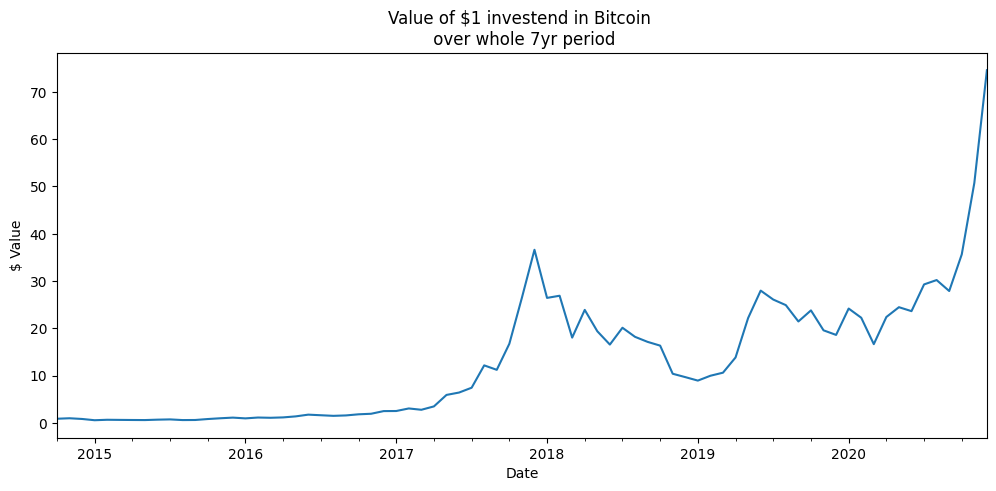

In [49]:
((1 + dffull['BTC-USD']).cumprod()).plot(figsize=(12,5))
plt.title('Value of $1 investend in Bitcoin \n over whole 7yr period')
plt.ylabel('$ Value')